In [1]:
import numpy as np
import glob
from collections import defaultdict

files = glob.glob('D:/nagahama/output/pickup_centerline/*.ply')


def read_ply_to_dict(file_path):
    coordinates_dict = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()

    header_ended = False
    for i, line in enumerate(lines):
        if line.strip() == "end_header":
            header_ended = True
            data_start = i + 1  # 数据从下一行开始
            break

    if not header_ended:
        raise ValueError("Invalid PLY file: missing 'end_header'.")

    for line in lines[data_start:]:
        parts = line.split()
        if len(parts) == 6:  # 确保行有完整顶点信息 (x, y, z, r, g, b)
            x, y, z = map(float, parts[:3])
            r, g, b = map(int, parts[3:6])
            rgb = (r, g, b)
            if rgb not in coordinates_dict:
                coordinates_dict[rgb] = []
            coordinates_dict[rgb].append((x, y, z))

    return coordinates_dict


def group_coordinates_by_color(files):
    grouped_coordinates = defaultdict(list)
    
    for file_path in files:
        coordinates = read_ply_to_dict(file_path)
        for color, coords in coordinates.items():
            # 计算重心
            center_x = sum(point[0] for point in coords) / len(coords)
            center_y = sum(point[1] for point in coords) / len(coords)
            center_z = sum(point[2] for point in coords) / len(coords)
            
            # 将每个点移动到以 (0, 0, 0) 为重心的坐标系
            centered_coords = [(point[0] - center_x, point[1] - center_y, point[2] - center_z) for point in coords]
            
            # 添加到对应颜色的组
            grouped_coordinates[color].append(centered_coords)
    
    return grouped_coordinates



# 示例用法
grouped_data = group_coordinates_by_color(files)

# 打印分组结果
for color, grouped_coords in grouped_data.items():
    print(f"Color {color}:")
    total_curves = len(grouped_coords)
    total_points = sum(len(coords) for coords in grouped_coords)
    print(f"  Total curves: {total_curves}")
    print(f"  Total points: {total_points}")
    print("-" * 30)



Color (80, 160, 160):
  Total curves: 3070
  Total points: 211076
------------------------------
Color (208, 160, 208):
  Total curves: 2849
  Total points: 76462
------------------------------
Color (144, 112, 176):
  Total curves: 2941
  Total points: 84961
------------------------------
Color (0, 208, 192):
  Total curves: 3071
  Total points: 215348
------------------------------


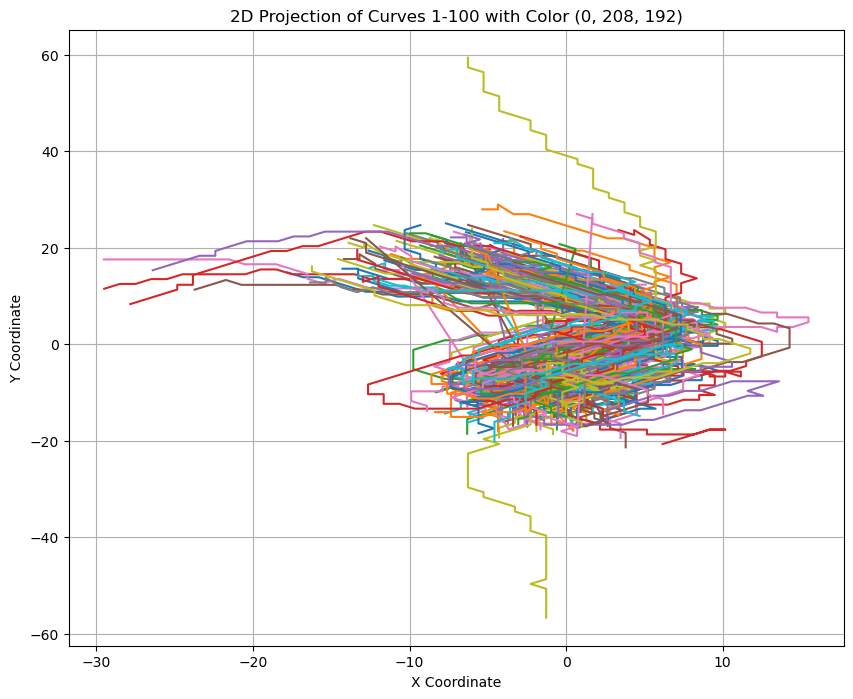

In [2]:
import matplotlib.pyplot as plt

def plot_2d_projection_by_range(grouped_data, target_color, n, m):
    if target_color not in grouped_data:
        print(f"Color {target_color} not found in data.")
        return
    
    curves = grouped_data[target_color]
    total_curves = len(curves)

    # 检查范围是否有效
    if n < 1 or m > total_curves or n > m:
        print(f"Invalid range: n={n}, m={m}. There are {total_curves} curves for color {target_color}.")
        return

    plt.figure(figsize=(10, 8))
    
    for i in range(n - 1, m):  # Python 索引从 0 开始，转换为 0-based 索引
        curve = curves[i]
        x_coords = [point[0] for point in curve]
        y_coords = [point[2] for point in curve]
        plt.plot(x_coords, y_coords, label=f"Curve {i + 1}")
    
    plt.title(f"2D Projection of Curves {n}-{m} with Color {target_color}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    # plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


# 示例用法
target_color = (0, 208, 192)
n = 1  # 从第 2 条曲线开始
m = 100  # 到第 5 条曲线结束
plot_2d_projection_by_range(grouped_data, target_color, n, m)
